In [28]:
from numpy import linalg
from scipy import signal
import numpy as np
from pylab import *
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import random

In [29]:
'''
In regular optical flow method, we assume the following:
	a) brightness constancy
	b) small motion
	c) Spatial coherence
Now, if the object were to move a larger distance then the traditional
optical flow method would work bad. This is why, we use gaussian pyramids
(coarse-to-fine) method to apply optical flow.

Pyramid is built by using multiple copies of the same image.
Each level in the pyramid is 1//4th of the size of the previous level and when stacked together
it looks like a pyramid. The lowest level is of the highest resolution and the highest level
is of the lowest resolution.

Algorithm for downsamples (to produce I[m//2,n//2](i+1) layer for I[m,n](i):
	a) Convolve I(i) with the Gaussian kernel, G.
	b) Remove every even numbered row and column			#up-sample by a factor of 2
	This follows that each image (I(i+1)next layer) is exactly one-quarter the area of its predecessor (I(i) current frame).

Algorithm for upsamples (to produce I[2m, 2n](i+1) layer for I[m,n](i)):
	a) Insert zero column and row alternatively. This ensure the I[2m, 2n]
	b) Convolve I[2m, 2n] with G of double the size to be used.

Optical Flow is implemeneted in the same as described in the previous program

We need to use the result of current iteration to be propagated to the next iteration and thats why we define the next function,
which calculates the optical flow in a same sized window.

Finally we write a function which combines all the above user-defined functions to include the Lucas Kanade algorithm iteratively over all the levels

'''

'\nIn regular optical flow method, we assume the following:\n\ta) brightness constancy\n\tb) small motion\n\tc) Spatial coherence\nNow, if the object were to move a larger distance then the traditional\noptical flow method would work bad. This is why, we use gaussian pyramids\n(coarse-to-fine) method to apply optical flow.\n\nPyramid is built by using multiple copies of the same image.\nEach level in the pyramid is 1//4th of the size of the previous level and when stacked together\nit looks like a pyramid. The lowest level is of the highest resolution and the highest level\nis of the lowest resolution.\n\nAlgorithm for downsamples (to produce I[m//2,n//2](i+1) layer for I[m,n](i):\n\ta) Convolve I(i) with the Gaussian kernel, G.\n\tb) Remove every even numbered row and column\t\t\t#up-sample by a factor of 2\n\tThis follows that each image (I(i+1)next layer) is exactly one-quarter the area of its predecessor (I(i) current frame).\n\nAlgorithm for upsamples (to produce I, 2n](i+1) layer

In [30]:
# function defines the gaussian function used for convolution which returns the
def GaussianFunction(x, sigma):
    if sigma == 0:
        return 0
    else:
        g = (1/math.sqrt(2*math.pi*sigma*sigma))*math.exp(-x*x)/(2*sigma*sigma)
    return g

In [31]:
# function returns the gaussian kernel using the GaussianFunction of size 3x3
def GaussianMask(sigma):
    g = []
    for i in range(-2, 3):			#creating a gaussian kernel of size 3x3
        g1 = GaussianFunction(i,sigma)
        g2 = GaussianFunction(i-0.5, sigma)
        g3 = GaussianFunction(i+0.5, sigma)
        gaussian = (g1+g2+g3)/3
        g.append(gaussian)
    return g

In [32]:
sigma = math.sqrt(2/(4*math.pi))
G = [] # Gaussian Kernel
G = GaussianMask(sigma)

In [33]:
def DownSample(I):
    Ix = Iy  = []
    I = np.array(I)
    S = np.shape(I)											#shape of the image
    for i in range(S[0]):
        Ix.extend([signal.convolve(I[i,:],G,'same')])		#convolution of the I[i] with G
    Ix = np.array(np.matrix(Ix))
    Iy = Ix[::2, ::2]										#selects the alternate column and row
    return Iy

In [34]:
def UpSample(I):
    I = np.array(I)
    S = np.shape(I)

    Ix = np.zeros((S[0], 2*S[1]))			#inserting alternate rows of zeros
    Ix[:, ::2] = I
    S1 = np.shape(Ix)
    Iy = np.zeros((2*S1[0], S1[1]))		#inserting alternate columns of zeros
    Iy[::2, :] = Ix
    Ig = cv2.GaussianBlur(Iy, (5,5), 1.5, 1.5)		#instead of using the user-defined gaussian function, I am using the Gaussian Blur functtion for double the size of gaussian kernel size
    return Ig

In [35]:
def LucasKanade(I1, I2):
    I1 = np.array(I1)
    I2 = np.array(I2)
    S = np.shape(I1)

    Ix = signal.convolve2d(I1,[[-0.25,0.25],[-0.25,0.25]],'same') + signal.convolve2d(I2,[[-0.25,0.25],[-0.25,0.25]],'same')
    Iy = signal.convolve2d(I1,[[-0.25,-0.25],[0.25,0.25]],'same') + signal.convolve2d(I2,[[-0.25,-0.25],[0.25,0.25]],'same')
    It = signal.convolve2d(I1,[[0.25,0.25],[0.25,0.25]],'same') + signal.convolve2d(I2,[[-0.25,-0.25],[-0.25,-0.25]],'same')

    features = cv2.goodFeaturesToTrack(I1, 10000, 0.01, 10)
    features = np.int0(features)

    u = v = np.ones((S))
    for l in features:
        j,i = l.ravel()
        IX = ([Ix[i-1,j-1],Ix[i,j-1],Ix[i-1,j-1],Ix[i-1,j],Ix[i,j],Ix[i+1,j],Ix[i-1,j+1],Ix[i,j+1],Ix[i+1,j-1]])
        IY = ([Iy[i-1,j-1],Iy[i,j-1],Iy[i-1,j-1],Iy[i-1,j],Iy[i,j],Iy[i+1,j],Iy[i-1,j+1],Iy[i,j+1],Iy[i+1,j-1]])
        IT = ([It[i-1,j-1],It[i,j-1],It[i-1,j-1],It[i-1,j],It[i,j],It[i+1,j],It[i-1,j+1],It[i,j+1],It[i+1,j-1]])

        # Using the minimum least squares solution approach
        LK = (IX,IY)
        LK = matrix(LK)
        LK_T = array(matrix(LK))
        LK = array(np.matrix.transpose(LK))

        #Psedudo Inverse
        A1 = np.dot(LK_T,LK)
        A2 = np.linalg.pinv(A1)
        A3 = np.dot(A2,LK_T)
        (u[i,j],v[i,j]) = np.dot(A3,IT) # we have the vectors with minimized square error

    u = np.flipud(u)
    v = np.flipud(v)
    return u,v

In [36]:
def LucasKanadeIterative(I1, I2, u1, v1):

    '''This function runs the LK Algorithm for the current section of pyramid iteratively.
We take a window of 5x5 and move from left top corner to right bottom corner in order to calculate the vectors for that window.
Once the whole image is done, we sum the vectors of current and previous levels.
    '''
    I1 = np.array(I1)
    I2 = np.array(I2)
    S = np.shape(I1)
    u1 = np.round(u1)
    v1 = np.round(v1)
    u = np.zeros(S)
    v = np.zeros(S)

    for i in range(2, S[0]-2):
        for j in range(2, S[1]-2):
            I1new = I1[i-2:i+3,j-2:j+3] 		# picking 5x5 pixels at a time
            lr = (i-2)+v1[i,j]				 	#Low Row Index
            hr = (i+2)+v1[i,j] 					#High Row Index
            lc = (j-2)+u1[i,j] 					#Low Column Index
            hc = (j+2)+u1[i,j] 					#High Column Index

            #window search and selecting the last window if it goes out of bounds
            if(lr < 0):
                lr = 0
                hr = 4
            if(lc < 0):
                lc = 0
                hc = 4
            if(hr > (len(I1[:,0]))-1):
                lr = len(I1[:,0])-5
                hr = len(I1[:,0])-1
            if(hc > (len(I1[0,:]))-1):
                lc = len(I1[0,:])-5
                hc = len(I1[0,:])-1
            if(np.isnan(lr)):
                lr = i-2
                hr = i+2
            if(np.isnan(lc)):
                lc = j-2
                hc = j+2

            lr = int(lr)
            hr =int(hr)
            lc = int(lc)
            hc = int(hc)
            #Selecting the same window for the second frame
            I2new = I2[lr:(hr+1),lc:(hc+1)]
            # Now applying LK for each window of the 2 images
            Ix = signal.convolve2d(I1new,[[-0.25,0.25],[-0.25,0.25]],'same') + signal.convolve2d(I2new,[[-0.25,0.25],[-0.25,0.25]],'same')
            Iy = signal.convolve2d(I1new,[[-0.25,-0.25],[0.25,0.25]],'same') + signal.convolve2d(I2new,[[-0.25,-0.25],[0.25,0.25]],'same')
            It = signal.convolve2d(I1new,[[0.25,0.25],[0.25,0.25]],'same') + signal.convolve2d(I2new,[[-0.25,-0.25],[-0.25,-0.25]],'same')

            IX =np.transpose(Ix[1:5,1:5])
            IY = np.transpose(Iy[1:5,1:5])
            IT = np.transpose(It[1:5,1:5])

            IX = IX.ravel()
            IY = IY.ravel()
            IT = IT.ravel()

            LK = (IX,IY)
            LK = np.matrix(LK)
            LK_T = np.array(np.matrix(LK))
            LK = np.array(np.matrix.transpose(LK))

            A1 = np.dot(LK_T,LK)
            A2 = np.linalg.pinv(A1)
            A3 = np.dot(A2,LK_T)
            (u[i,j],v[i,j]) = np.dot(A3,IT)

    #This was commented by other file
    #u = u+u1
    #v = v + v1
    r = np.mat(transpose(LK))*np.mat(LK)
    r = 1.0/(linalg.cond(r))
    return u,v,r

In [64]:
'''
warp is: if you apply LK for two images and you get say u=2 and v=3 for a certain pixel, in this case applying warping of one image is to increase the x-coordinate of that pixel by 2 and increase it's y-coordinate by 3, and then make this for all other pixels in the image using the associated u and v.

In step two you need to warp one image using the u and v motion vectors that you get from the first step, if your estimate to u and v from the first step is accurate then after applying the second step the two images will coincides on each other, and this means that if you apply Lucas Kanade algorithm on these two images(step 3) you will get u=0 and v=0 because the two images coincides on each others.
but in real situations you will not get accurate u and v from the first iteration.
so after applying the warping there will be a smaller motion between the two images and if you apply Lucas Kanade algorithm between these two images you will get a smaller u and v and you refine the motion vectors by the following:
are zeros or very small.

this is iterative LK without pyramids.

https://dsp.stackexchange.com/questions/13234/iterative-lucas-kanade-algorithm

'''
def LK_Pyramid(Im1, Im2, iteration, level):

    ''' The function uses all the above defined function to implement LK algorithm in a multi-resolution Gaussian pyramid
    framework. We use the following :
    window size of 3x3
    Pyramid size = 3 levels

    Starting from the lower most level, at each level we use the iterative LK algorithm and then warp and upsample it so that it can be used for the next level.
    '''
    I1 = np.array(Im1)
    I2 = np.array(Im2)
    S = np.shape(I1)

    pyramid1 = np.empty((S[0],S[1],level))
    pyramid2 = np.empty((S[0],S[1],level))
    pyramid1[:,:,0] = I1 			#since the lowest level is the original imae
    pyramid2[:,:,0] = I2 			#since the lowest level is the original image

    #creating the pyramid by downsampling the original image
    for i in range(1, level):
        I1 = DownSample(I1)
        I2 = DownSample(I2)
        pyramid1[0:np.shape(I1)[0], 0:np.shape(I1)[1], i] = I1
        pyramid2[0:np.shape(I2)[0], 0:np.shape(I2)[1], i] = I2

    level0_I1 = pyramid1[0:(len(pyramid1[:,0])//4),0:(len(pyramid1[0,:])//4),2]
    level0_I2 = pyramid2[0:(len(pyramid2[:,0])//4),0:(len(pyramid2[0,:])//4),2]
    (u,v) = LucasKanade(Im1, Im2)

    for i in range(0, iteration):
        (u,v,r) = LucasKanadeIterative(level0_I1, level0_I2, u, v)
    u_l0 = u
    v_l0 = v
    I_l0 = level0_I1
    #u_l0[np.where(u_l0 == 0)] = nan
    #v_l0[np.where(v_l0 == 0)] = nan

    #for level 1
    k = 1
    u1 = UpSample(u)
    v1 = UpSample(v)
    I1new = pyramid1[0:(len(pyramid1[:,0])//(2**(level-k-1))),0:(len(pyramid1[0,:])//(2**(level-k-1))),level-k-1]
    I2new = pyramid2[0:(len(pyramid2[:,0])//(2**(level-k-1))),0:(len(pyramid2[0,:])//(2**(level-k-1))),level-k-1]
    (u,v,r) = LucasKanadeIterative(I1new, I2new, u1, v1)

    u_l1 = u
    v_l1 = v
    I_l1 = I1new
    #u_l1[np.where(u_l1 == 0)] = nan
    #v_l1[np.where(v_l1 == 0)] = nan

    k = 2
    u1 = UpSample(u)
    v1 = UpSample(v)
    I1new = pyramid1[0:(len(pyramid1[:,0])//(2**(level-k-1))),0:(len(pyramid1[0,:])//(2**(level-k-1))),level-k-1]
    I2new = pyramid2[0:(len(pyramid2[:,0])//(2**(level-k-1))),0:(len(pyramid2[0,:])//(2**(level-k-1))),level-k-1]
    (u,v,r) = LucasKanadeIterative(I1new, I2new, u1, v1)

    u_l2 = u
    v_l2 = v
    I_l2 = I1new
    #u_l2[np.where(u_l2 == 0)] = nan
    #v_l2[np.where(v_l2 == 0)] = nan

    colours = "bgrcmykw"
    colour_index = random.randrange(0,8)
    c=colours[colour_index]
    c="g"
    
    ######### Base Level ##########
    plt.figure()
    plt.imshow(I_l0,cmap = cm.gray)
    plt.title('Level 0 - Base level')
    quiver(u_l0,v_l0,color = c)
    
    ######### Level 1 ##########
    
    #c=colours[colour_index]
    plt.figure()
    plt.imshow(I_l1,cmap = cm.gray)
    plt.title('Level 1')
    quiver(u_l1,v_l1,color = c)
    
    ######### Level 2 ##########
    #c=colours[colour_index]
    plt.figure()
    plt.imshow(I_l2,cmap = cm.gray)
    plt.title('Level 2')
    plt.quiver(u_l2,v_l2,color = c)
    plt.show()
    
    ######### Level Final ##########
    
    u_fin = UpSample(UpSample(u_l0)) + UpSample(u_l1) + u_l2
    v_fin = UpSample(UpSample(v_l0)) + UpSample(v_l1) + v_l2
    
    #u_fin[np.where(u_fin == 0)] = nan
    #v_fin[np.where(v_fin == 0)] = nan
    
    print(u_l0)
    print(UpSample(UpSample(u_l0)).shape)
    print(UpSample(UpSample(u_l0)))
    
    print(UpSample(u_l1))
    
    print(UpSample(u_l2))
    
    
    print("U FINAL")
    print(u_fin)
    
    plt.figure()
    plt.imshow(I_l2,cmap = cm.gray)
    plt.title('Final estimation of U and V')
    plt.quiver(u_fin,v_fin,color = c)
    plt.show()
    '''
        plt.figure(1)
    plt.imshow(pyramid1[:,:,0], cmap = cm.gray)
    plt.figure(2)
    plt.imshow(pyramid1[:,:,1], cmap = cm.gray)
    plt.figure(3)
    plt.imshow(pyramid1[:,:,2], cmap = cm.gray)
    plt.figure(4)
    plt.imshow(level0_I1, cmap = cm.gray)
    plt.show()
    
    
    
    '''
    arrow = arrow = np.sqrt(u_fin**2+v_fin**2)
    return u_fin, v_fin,arrow


In [66]:
def getCoor(hx, hy, arrow, step = 20, percent = 0.1):
    y, x= np.meshgrid(np.arange(0, hx.shape[0], step), np.arange(0, hx.shape[1], step))
    coor = np.vstack((x.flatten(), y.flatten()))
    
    arrow = arrow[y, x]
    index = np.argsort(arrow.flatten())
    coor = coor[:, index[int(-len(index)*percent):]]
    return coor

def drawArrow(img, hx, hy, coor, scale=50):
    color = (0, 255, 255)
    mask = np.zeros_like(img)
    m = np.max((np.abs(hx), np.abs(hy)))
    if m < 0.5:
        scale /=0.5
    for i in range(coor.shape[1]):
        x1 = int(coor[0, i])
        y1 = int(coor[1, i])
        x2 = int(coor[0, i]+hx[y1, x1]*scale)
        y2 = int(coor[1, i]+hy[y1, x1]*scale)
        mask = cv2.line(mask, (x1, y1), (x2, y2), color, thickness=1)
        mask = cv2.circle(mask,(x1,y1), 3, color, -1)
    out = cv2.add(img, mask)
    return out

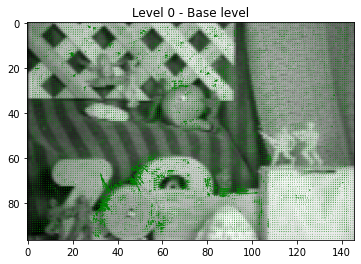

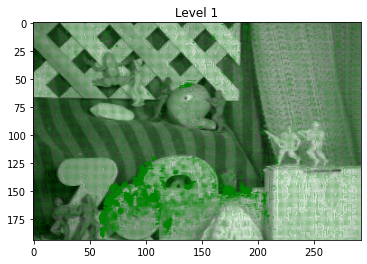

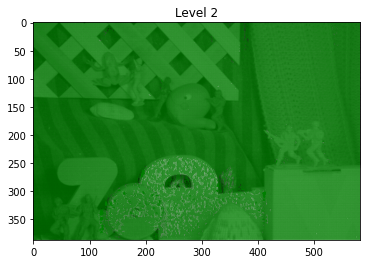

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          1.02225052 ...  0.10717511  0.
   0.        ]
 ...
 [ 0.          0.          0.74861329 ... -0.09411328  0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(388, 584)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.00021253 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [

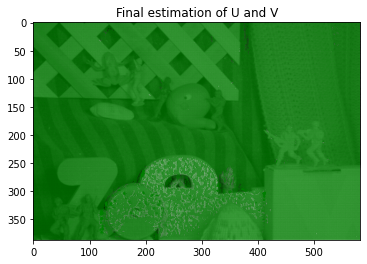

True

In [68]:
def run(prevImg, nextImg):
    prevGray = cv2.cvtColor(prevImg, cv2.COLOR_BGR2GRAY)
    nextGray = cv2.cvtColor(nextImg, cv2.COLOR_BGR2GRAY)
    hx, hy, arrow= LK_Pyramid(prevGray, nextGray, 3, 3)
    coor = getCoor(hx, hy, arrow)
    out = drawArrow(prevImg, hx, hy, coor)
    return out

prevImg = cv2.imread('dataset/eval-data-gray/Army/frame07.png')
nextImg = cv2.imread('dataset/eval-data-gray/Army/frame08.png')

out = run(prevImg,nextImg)
cv2.imwrite("test-pyramid.png", out)